In [3]:
import cv2
import numpy as np
import open3d as o3d
from PIL import Image
from inference import Inferencer
import matplotlib.pyplot as plt

def draw_point_cloud(color, depth, camera_intrinsics, use_mask = False, use_inpainting = True, scale = 1000.0, inpainting_radius = 5, fault_depth_limit = 0.2, epsilon = 0.01):
    """
    Given the depth image, return the point cloud in open3d format.
    The code is adapted from [graspnet.py] in the [graspnetAPI] repository.
    """
    d = depth.copy()
    c = color.copy() / 255.0
    
    if use_inpainting:
        fault_mask = (d < fault_depth_limit * scale)
        d[fault_mask] = 0
        inpainting_mask = (np.abs(d) < epsilon * scale).astype(np.uint8)  
        d = cv2.inpaint(d, inpainting_mask, inpainting_radius, cv2.INPAINT_NS)

    fx, fy = camera_intrinsics[0, 0], camera_intrinsics[1, 1]
    cx, cy = camera_intrinsics[0, 2], camera_intrinsics[1, 2]

    xmap, ymap = np.arange(d.shape[1]), np.arange(d.shape[0])
    xmap, ymap = np.meshgrid(xmap, ymap)

    points_z = d / scale
    points_x = (xmap - cx) / fx * points_z
    points_y = (ymap - cy) / fy * points_z
    points = np.stack([points_x, points_y, points_z], axis = -1)

    if use_mask:
        mask = (points_z > 0)
        points = points[mask]
        c = c[mask]
    else:
        points = points.reshape((-1, 3))
        c = c.reshape((-1, 3))
    cloud = o3d.geometry.PointCloud()
    cloud.points = o3d.utility.Vector3dVector(points)
    cloud.colors = o3d.utility.Vector3dVector(c)
    return cloud



In [4]:
inferencer = Inferencer()
rgb = np.array(Image.open('transcg/scene4/6/rgb1.png'), dtype = np.float32)
depth = np.array(Image.open('transcg/scene4/6/depth1.png'), dtype = np.float32)

# depth_gt = np.array(Image.open('transcg/scene1/1/depth1-gt.png'), dtype = np.float32)
print(rgb.shape, depth.shape)

(720, 1280, 3) (720, 1280)


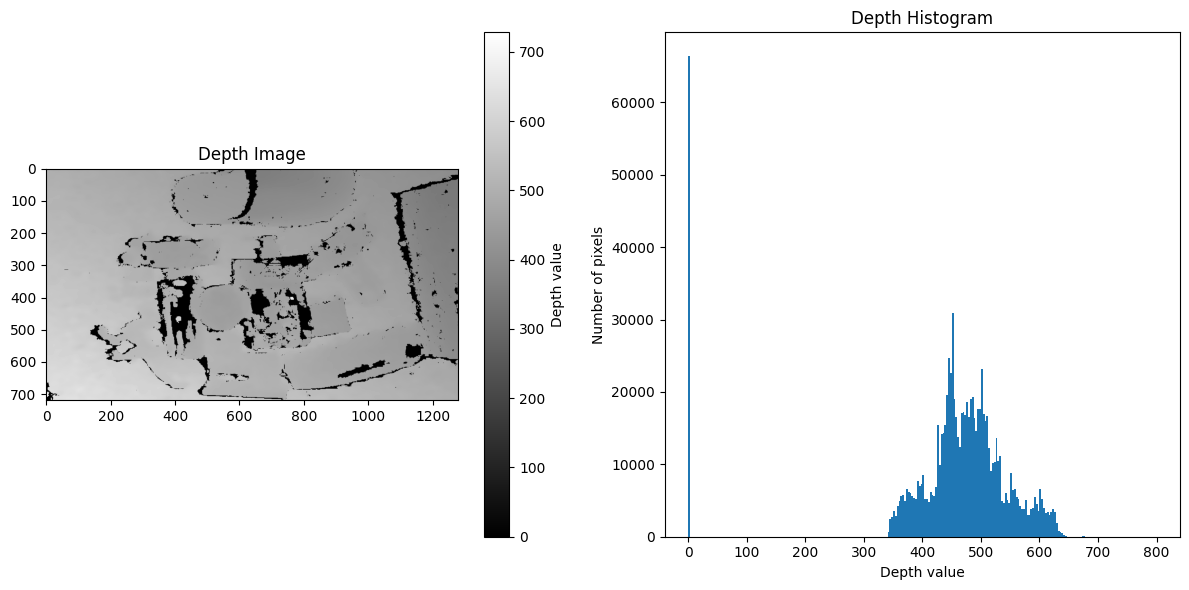

In [7]:

# Create a histogram of the depth values
hist, bins = np.histogram(depth.ravel(), 256, [0, 800])

# Plotting
plt.figure(figsize=(12, 6))

# Display the depth image
plt.subplot(1, 2, 1)
plt.imshow(depth, cmap='gray')
plt.colorbar(label='Depth value')
plt.title("Depth Image")

# Display the histogram
plt.subplot(1, 2, 2)
plt.bar(bins[:-1], hist, width=bins[1] - bins[0], align="edge")
plt.xlabel("Depth value")
plt.ylabel("Number of pixels")
plt.title("Depth Histogram")

plt.tight_layout()
plt.show()


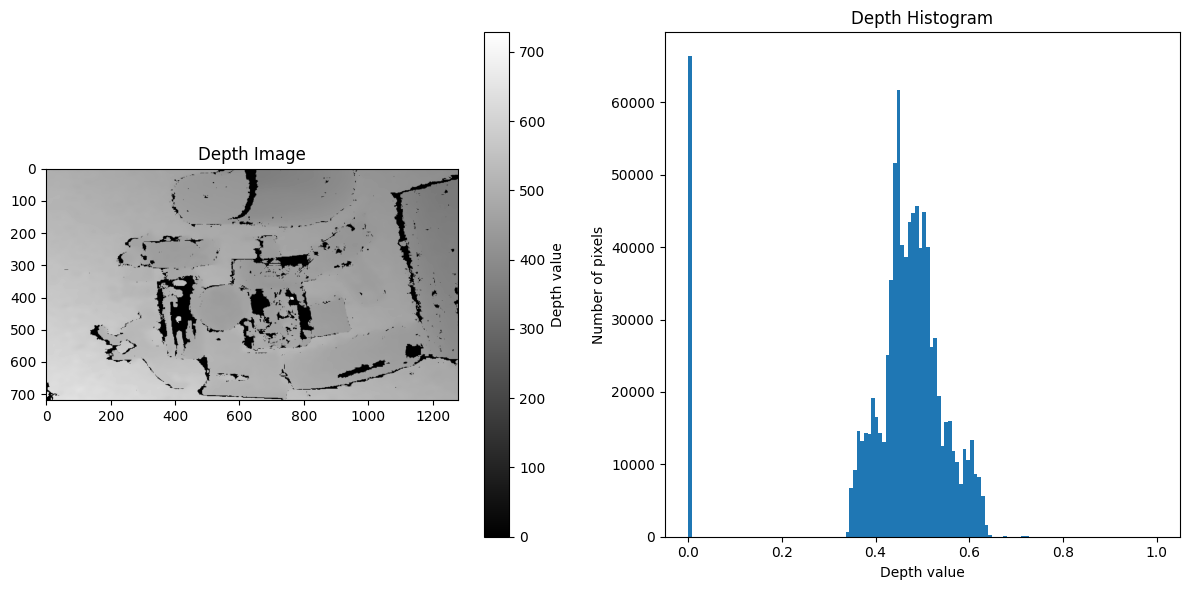

In [5]:
depth_shifted = depth / 1000

# Create a histogram of the depth values
hist, bins = np.histogram(depth_shifted.ravel(), 128, [0,  1])

# Plotting
plt.figure(figsize=(12, 6))

# Display the depth image
plt.subplot(1, 2, 1)
plt.imshow(depth, cmap='gray')
plt.colorbar(label='Depth value')
plt.title("Depth Image")

# Display the histogram
plt.subplot(1, 2, 2)
plt.bar(bins[:-1], hist, width=bins[1] - bins[0], align="edge")
plt.xlabel("Depth value")
plt.ylabel("Number of pixels")
plt.title("Depth Histogram")

plt.tight_layout()
plt.show()


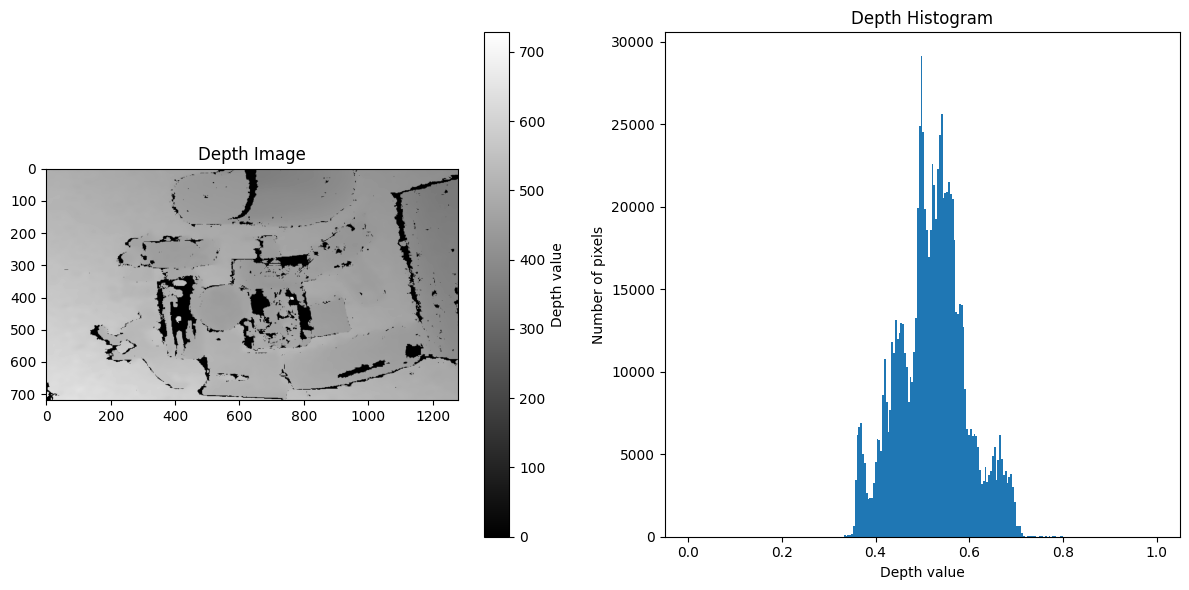

In [7]:
res_infered, depth_infered = inferencer.inference(rgb, depth_shifted, depth_coefficient = 5, inpainting = True)

hist, bins = np.histogram(res_infered.ravel(), 256, [0,  1])

# Plotting
plt.figure(figsize=(12, 6))

# Display the depth image
plt.subplot(1, 2, 1)
plt.imshow(depth, cmap='gray')
plt.colorbar(label='Depth value')
plt.title("Depth Image")

# Display the histogram
plt.subplot(1, 2, 2)
plt.bar(bins[:-1], hist, width=bins[1] - bins[0], align="edge")
plt.xlabel("Depth value")
plt.ylabel("Number of pixels")
plt.title("Depth Histogram")

plt.tight_layout()
plt.show()

In [8]:
cam_intrinsics = np.load('intrinsics.npy')

res_clip = np.clip(res_infered, 0.3, 1.0) # default 0.3, 1.0
depth_clip = np.clip(depth_infered, 0.3, 1.0) # default 0.3, 1.0

cloud = draw_point_cloud(rgb, res_clip, cam_intrinsics, scale = 1.0)

frame = o3d.geometry.TriangleMesh.create_coordinate_frame(0.1)
sphere = o3d.geometry.TriangleMesh.create_sphere(0.002,20).translate([0,0,0.490])
o3d.visualization.draw_geometries([cloud, frame, sphere])